In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pitches = pd.read_csv('/Users/JKovach/Downloads/mlb-pitch-data-20152018/pitches.csv')
pitches.head(10)

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,0.416,2.963,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665,...,3,0.0,2.015000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.191,2.347,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043,...,4,0.0,2.015000e+09,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,-0.518,3.284,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368,...,5,0.0,2.015000e+09,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,-0.641,1.221,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104,...,6,0.0,2.015000e+09,0.0,2.0,0.0,4.0,0.0,0.0,0.0
4,-1.821,2.083,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280,...,7,0.0,2.015000e+09,1.0,2.0,0.0,5.0,0.0,0.0,0.0
5,0.627,2.397,92.9,84.8,2743.856,148.110,-45.7,3.7,23.7,13.590,...,8,0.0,2.015000e+09,2.0,2.0,0.0,6.0,0.0,0.0,0.0
6,-1.088,1.610,93.3,85.3,2848.535,147.044,-46.3,3.6,23.7,14.549,...,12,0.0,2.015000e+09,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7,-0.257,2.047,89.3,82.4,1433.743,185.948,7.3,4.8,23.8,-1.339,...,13,0.0,2.015000e+09,1.0,0.0,1.0,2.0,0.0,0.0,0.0
8,1.470,2.350,92.1,85.0,2666.090,146.146,-45.0,4.0,23.8,13.808,...,17,0.0,2.015000e+09,0.0,0.0,1.0,1.0,0.0,1.0,0.0
9,-1.337,1.898,89.3,82.0,1384.143,174.388,2.0,4.9,23.8,1.218,...,18,0.0,2.015000e+09,1.0,0.0,1.0,2.0,0.0,1.0,0.0


In [3]:
# Feature engineering
fastballs = ['FF', 'FC', 'SI', 'FT', 'FS', 'FA']
offspeed = ['CH', 'CU', 'SL', 'SC', 'KC', 'EP', 'KN']

def fastbool(pitch):
    if pitch in fastballs:
        return 1
    elif pitch in offspeed:
        return 0
    else:
        return np.nan

# Create target variable
pitches['is_fastball'] = pitches['pitch_type'].apply(fastbool)

pitches.info()
# Why am I not getting count values?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2867154 entries, 0 to 2867153
Data columns (total 41 columns):
px                 float64
pz                 float64
start_speed        float64
end_speed          float64
spin_rate          float64
spin_dir           float64
break_angle        float64
break_length       float64
break_y            float64
ax                 float64
ay                 float64
az                 float64
sz_bot             float64
sz_top             float64
type_confidence    float64
vx0                float64
vy0                float64
vz0                float64
x                  float64
x0                 float64
y                  float64
y0                 float64
z0                 float64
pfx_x              float64
pfx_z              float64
nasty              float64
zone               float64
code               object
type               object
pitch_type         object
event_num          int64
b_score            float64
ab_id              float64
b

In [4]:
# Check correlation and to identify highly correlated features
import seaborn as sns

pcor = pitches.corr()
cor_target = abs(pcor['is_fastball'])
relevant_features = cor_target[cor_target>0.3]
print(relevant_features)

# Drop
# ['IN', 'FO', 'PO', 'UN', 'AB']

# Can cleaning process affect correlation?

pz             0.302109
start_speed    0.771744
end_speed      0.750162
spin_rate      0.609309
ay             0.623595
az             0.710303
vy0            0.771620
vz0            0.398328
pfx_z          0.670819
is_fastball    1.000000
Name: is_fastball, dtype: float64


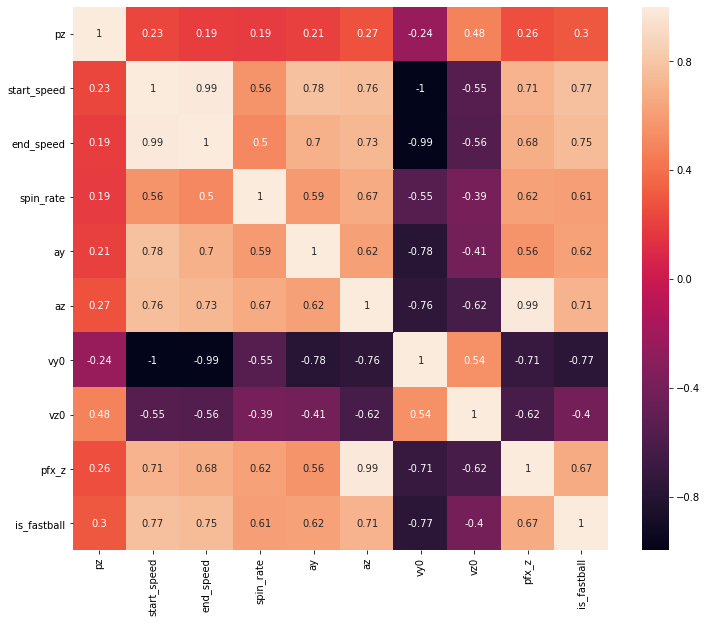

In [5]:
# Create new df with only highly correlated features
redux_pitch = pitches[['pz', 'start_speed', 'end_speed', 'spin_rate', 'ay', 
                       'az', 'vy0', 'vz0', 'pfx_z', 'is_fastball']]

plt.figure(figsize=(12,10))
rpcor = redux_pitch.corr()
sns.heatmap(rpcor, annot=True)
plt.show()

In [6]:
redux_pitch = redux_pitch.drop(['end_speed', 'vy0', 'pfx_z'], 1)
redux_pitch.isnull().sum()

pz             14189
start_speed    14114
spin_rate      14189
ay             14189
az             14189
vz0            14189
is_fastball    21890
dtype: int64

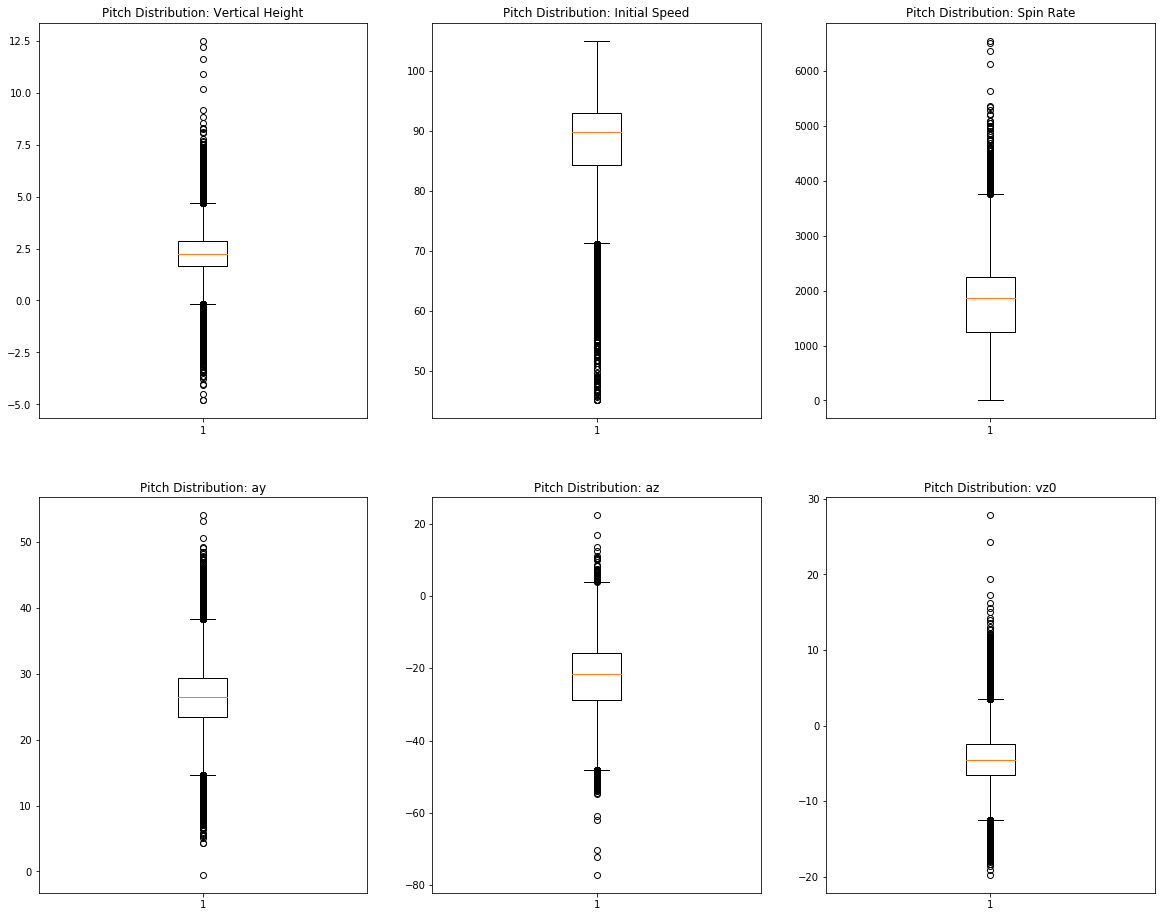

In [7]:
# Less than 10% nan values, drop nan
redux_pitch = redux_pitch.dropna(how='any')
plt.figure(figsize=(20,16))

plt.subplot(2,3,1)
plt.boxplot(redux_pitch['pz'])
plt.title('Pitch Distribution: Vertical Height')

plt.subplot(2,3,2)
plt.boxplot(redux_pitch['start_speed'])
plt.title('Pitch Distribution: Initial Speed')

plt.subplot(2,3,3)
plt.boxplot(redux_pitch['spin_rate'])
plt.title('Pitch Distribution: Spin Rate')

plt.subplot(2,3,4)
plt.boxplot(redux_pitch['ay'])
plt.title('Pitch Distribution: ay')

plt.subplot(2,3,5)
plt.boxplot(redux_pitch['az'])
plt.title('Pitch Distribution: az')

plt.subplot(2,3,6)
plt.boxplot(redux_pitch['vz0'])
plt.title('Pitch Distribution: vz0')
plt.show()

In [8]:
# Check outliers and distribution
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(redux_pitch['start_speed'])
norm_stats = normaltest(redux_pitch['start_speed'])
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

q75, q25 = np.percentile(redux_pitch['start_speed'], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((redux_pitch['start_speed'] > max_val) 
                      | (redux_pitch['start_speed'] < min_val))[0]))
    ))

Jarque-Bera test statistics is 228367.44027917736 and p value is 0.0
Normality test statistics is 188031.02357889334 and p value is 0.0
The score threshold is: 1.0
Number of outliers is: 83064
The score threshold is: 1.5
Number of outliers is: 14487
The score threshold is: 2.0
Number of outliers is: 2390
The score threshold is: 2.5
Number of outliers is: 378
The score threshold is: 3.0
Number of outliers is: 133
The score threshold is: 3.5
Number of outliers is: 66
The score threshold is: 4.0
Number of outliers is: 34
The score threshold is: 4.5
Number of outliers is: 4


Jarque-Bera test statistics is 293049.42528930394 and p value is 0.0
Normality test statistics is 233376.812546898 and p value is 0.0
The score threshold is: 1.0
Number of outliers is: 82424
The score threshold is: 1.5
Number of outliers is: 14487
The score threshold is: 2.0
Number of outliers is: 0
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


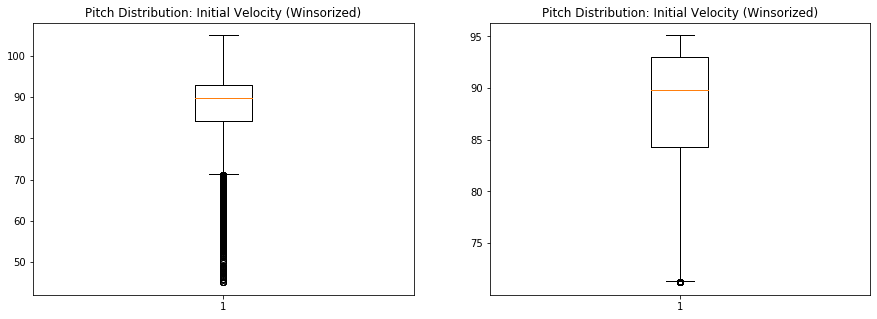

In [9]:
# Check outliers and distribution after winsorization
from scipy.stats.mstats import winsorize

redux_pitch['w_start_speed'] = winsorize(redux_pitch['start_speed'], (0.005,0.1))

jb_stats = jarque_bera(redux_pitch['w_start_speed'])
norm_stats = normaltest(redux_pitch['w_start_speed'])
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

q75, q25 = np.percentile(redux_pitch['w_start_speed'], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((redux_pitch['w_start_speed'] > max_val) 
                      | (redux_pitch['w_start_speed'] < min_val))[0]))
    ))

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.boxplot(redux_pitch['start_speed'])
plt.title('Pitch Distribution: Initial Velocity (Winsorized)')

plt.subplot(1,2,2)
plt.boxplot(redux_pitch['w_start_speed'])
plt.title('Pitch Distribution: Initial Velocity (Winsorized)')
plt.show()
# Winsorization seems effective, let's apply to the other 

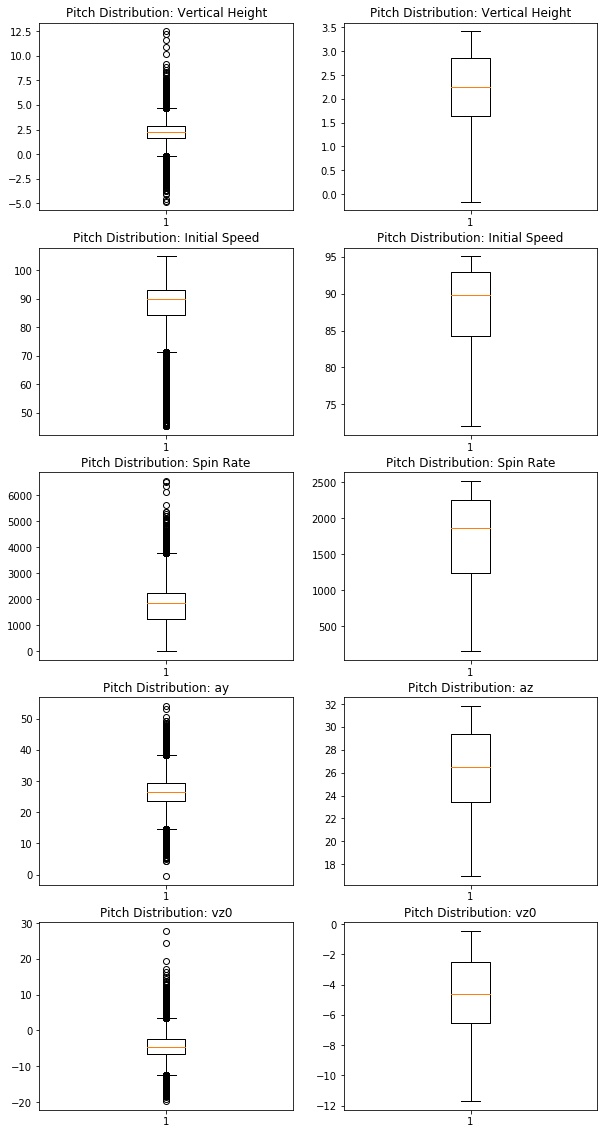

In [10]:
# Winsorize all relevant variables and check for distribution
redux_pitch['w_pz'] = winsorize(redux_pitch['pz'], (0.008,0.1))
redux_pitch['w_start_speed'] = winsorize(redux_pitch['start_speed'], (0.007,0.1))
redux_pitch['w_spin_rate'] = winsorize(redux_pitch['spin_rate'], (0.005,0.1))
redux_pitch['w_ay'] = winsorize(redux_pitch['ay'], (0.005,0.1))
redux_pitch['w_vz0'] = winsorize(redux_pitch['vz0'], (0.005,0.1))
# Does each tuple need to match?

plt.figure(figsize=(10,20))

plt.subplot(5,2,1)
plt.boxplot(redux_pitch['pz'])
plt.title('Pitch Distribution: Vertical Height')

plt.subplot(5,2,2)
plt.boxplot(redux_pitch['w_pz'])
plt.title('Pitch Distribution: Vertical Height')

plt.subplot(5,2,3)
plt.boxplot(redux_pitch['start_speed'])
plt.title('Pitch Distribution: Initial Speed')

plt.subplot(5,2,4)
plt.boxplot(redux_pitch['w_start_speed'])
plt.title('Pitch Distribution: Initial Speed')

plt.subplot(5,2,5)
plt.boxplot(redux_pitch['spin_rate'])
plt.title('Pitch Distribution: Spin Rate')

plt.subplot(5,2,6)
plt.boxplot(redux_pitch['w_spin_rate'])
plt.title('Pitch Distribution: Spin Rate')

plt.subplot(5,2,7)
plt.boxplot(redux_pitch['ay'])
plt.title('Pitch Distribution: ay')

plt.subplot(5,2,8)
plt.boxplot(redux_pitch['w_ay'])
plt.title('Pitch Distribution: az')

plt.subplot(5,2,9)
plt.boxplot(redux_pitch['vz0'])
plt.title('Pitch Distribution: vz0')

plt.subplot(5,2,10)
plt.boxplot(redux_pitch['w_vz0'])
plt.title('Pitch Distribution: vz0')
plt.show()

In [11]:
# Gaussian NB for Model #1
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

y = redux_pitch['is_fastball']
X = redux_pitch.drop(['is_fastball'],1)

gnb = GaussianNB()
gnb.fit(X, y)
y_pred = gnb.predict(X)

print('Number of mislabeled points out of {}: {}'.format(
    X.shape[0],
    (y != y_pred).sum()
))
print('Accuracy Rate: {}'.format((X.shape[0] - (y != y_pred).sum())/X.shape[0]))

# Confusion Matrix
confusion_matrix(y, y_pred)

Number of mislabeled points out of 2845264: 273078
Accuracy Rate: 0.9040236688054254


array([[ 969027,   87403],
       [ 185675, 1603159]])

In [12]:
# In progress

# We want to target pitch type instead of just determining if the pitch is fastball or offspeed
# Start with decision tree model
from sklearn import tree
from IPython.display import Image
import pydotplus, graphviz



pitch_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=2,
    max_depth=4,
)
pitch_tree.fit(X, y)

dot_data = tree.export_graphviz(
    pitch_tree, out_file=None,
    feature_names=X.columns,
    

KeyboardInterrupt: 